In [1]:
import numpy as np
import pandas as pd

import json
import itertools
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

## Pull Spotify Data

In [2]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [3]:
# Pull data
TRACK_DATA_PATH = "data/tracks_5kalbums.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 11841 songs from data/tracks_5kalbums.json
First ten songs: [['000InFFKfurNhrCj7yfMdM', 'Park Bench People', 1], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 70], ['00518PumkDdn560MsfLofT', 'The Fuss', 46], ['005FoVr63RI753jsNjfLax', 'Black Panther', 31], ['009Mof2o4aS1P2l3FbaEpa', 'Quetzal', 30], ['009TjPzPuetzFiJNnBEVrV', 'Used and Abused', 51], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 68], ['00KiXBZT9vf1XhcqkFrzug', 'Downward', 46], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 69], ['00Le8soPbjYT0TxmXflHmi', 'A God Who Sees (Me & Lucy)', 39]]


## Data Exploration

/Users/etang/dev/SoundScorer221/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


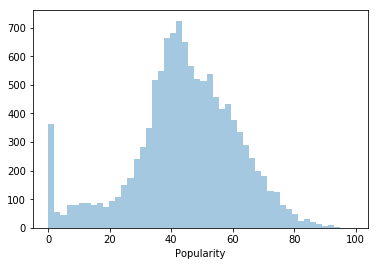

In [4]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [5]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['0s3nnoMeVWz3989MkNQiRf', 'Lucid Dreams', 93],
 ['14JzyD6FlBD5z0wV5P07YI', "when the party's over", 93],
 ['1xzBco0xcoJEDXktl7Jxrr', 'Mo Bamba', 93],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 93],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 94],
 ['1A6OTy97kk0mMdm78rHsm8',
  'Sunflower - Spider-Man: Into the Spider-Verse',
  95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 95],
 ['7l3E7lcozEodtVsSTCkcaA', 'ZEZE (feat. Travis Scott & Offset)', 95],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  99]]

## Feature Extraction

In [6]:
# audio_features provides high-level Echo Nest features
sp.audio_features(songs[0][0])

[{'danceability': 0.658,
  'energy': 0.379,
  'key': 5,
  'loudness': -11.763,
  'mode': 0,
  'speechiness': 0.0444,
  'acousticness': 0.367,
  'instrumentalness': 0.000493,
  'liveness': 0.0728,
  'valence': 0.81,
  'tempo': 135.991,
  'type': 'audio_features',
  'id': '000InFFKfurNhrCj7yfMdM',
  'uri': 'spotify:track:000InFFKfurNhrCj7yfMdM',
  'track_href': 'https://api.spotify.com/v1/tracks/000InFFKfurNhrCj7yfMdM',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/000InFFKfurNhrCj7yfMdM',
  'duration_ms': 315707,
  'time_signature': 4}]

In [7]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            if not track_feats[j]:
                continue # song not found in Spotify
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(filter(None, track_feats))
    return all_feats

In [8]:
feats = features(songs)
feats[100]

{'danceability': 0.964,
 'energy': 0.502,
 'key': 0,
 'loudness': -7.604,
 'mode': 1,
 'speechiness': 0.191,
 'acousticness': 0.00383,
 'instrumentalness': 0,
 'liveness': 0.0874,
 'valence': 0.551,
 'tempo': 127.993,
 'type': 'audio_features',
 'id': '04yv0dtqVm9u745efIuxbZ',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'duration_ms': 263933,
 'time_signature': 4,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69}

#### Artist Feature Extraction

In [9]:
def get_trackid_artistid_dict(tracks):
    """
    Given list of track_ids
    returns dictionary from all track_ids to artist IDs
    """
    track_artist_dict = {}
    for i in range(0, len(tracks), 50):
        track_ids = tracks[i : i + 50]
        track_infos = sp.tracks(track_ids)["tracks"]
        assert len(track_ids) == len(track_infos)
        for track_id, info in zip(track_ids, track_infos):
            if not info:
                continue # song not found in Spotify
            track_artist_dict[track_id] = info["artists"][0]["id"]
        if len(track_artist_dict) % 1000 == 0:
            print("Stored {} artist IDs".format(len(track_artist_dict)))
            print(list(track_artist_dict.items())[-1:])
    print("Stored {} artist IDs".format(len(track_artist_dict)))
    return track_artist_dict

In [10]:
def get_artistid_to_features_dict(artist_ids):
    """
    Given iterable of artist_ids, returns a map from artist_id to feature_dict for each artist
    e.g. {"093sDFBR924": {"followers" : 1038, "genres": ["pop", "rock"]},
            "RV3910FWS": {"followers" : 31001, "genres": ["country"]}
    """
    feature_dict = {}
    unique_ids = list(set(artist_ids))
    for i in range(0, len(unique_ids), 50):
        artist_ids_chunk = unique_ids[i : i + 50]
        artist_infos = sp.artists(artist_ids_chunk)["artists"]
        assert len(artist_infos) == len(artist_ids_chunk)
        for artist_id, info in zip(artist_ids_chunk, artist_infos):
            if not info:
                continue
            feature_dict[artist_id] = {
                "artist_followers": info["followers"]["total"],
                "artist_popularity": info["popularity"],
                "artist_genres": info["genres"]
            }
        if len(feature_dict) % 1000 == 0:
            print("Stored {} artists' features".format(len(feature_dict)))
            print(list(feature_dict.items())[-1:])
    print("Stored {} artists' features".format(len(feature_dict)))
    return feature_dict

In [11]:
def add_artist_features(features_list):
    """
    Takes in a list of feature dictionaries, adds artist features
    Requires that track_id be a feature in each song
    """
    # TODO: Could speed up by adding parameters to read or write these dictionaries from files
    features_list = feats
    track_ids = [f["id"] for f in features_list]
    print("BUILDING TRACK ID -> ARTIST ID DICTIONARY")
    track_artist_dict = get_trackid_artistid_dict(track_ids) 
    artist_ids = list(set(track_artist_dict.values()))
    print("BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY")
    artist_feature_dict = get_artistid_to_features_dict(artist_ids)
    features_list = [f for f in features_list if f["id"] in track_artist_dict and track_artist_dict[f["id"]] in artist_feature_dict]
    for features in features_list:
        track_artist_features = artist_feature_dict[track_artist_dict[features["id"]]]
        features.update(track_artist_features)
    return features_list

In [12]:
feats = add_artist_features(feats)
feats[100]

BUILDING TRACK ID -> ARTIST ID DICTIONARY
Stored 1000 artist IDs
[('0hpVsKtKOhxY3QYtzat4YI', '25KNo5GDS6ZpLkjasaecA3')]
Stored 2000 artist IDs
[('1M732H32aWAHYGDBOFU2br', '2J0JN7EFN10G1Tty6hX0AN')]
Stored 3000 artist IDs
[('21QNvLDoeQS1G4FxRvZNBL', '0Y4inQK6OespitzD6ijMwb')]
Stored 4000 artist IDs
[('2gafFAtDIGgDQLiEpRokIx', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 5000 artist IDs
[('3LjvFUqQi5LoqaRK6CLwMk', '1dfeR4HaWDbWqFHLkxsg1d')]
Stored 6000 artist IDs
[('3y6GnNl3mK2Rqw5N6vA5Se', '74gcBzlQza1bSfob90yRhR')]
Stored 7000 artist IDs
[('4eLHWCv6pLrxvpKomdGx5w', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 8000 artist IDs
[('5J3Rb54DgCiN1OLIuKu1sL', '2vGA5qCDLZGW6exRQgKfLL')]
Stored 9000 artist IDs
[('60mz2UG8P6BTE0sSl1MNMJ', '1vaOLxWPpsv5LVsSHBy9tF')]
Stored 10000 artist IDs
[('6gC1f3S8JdxFHcOTlz1sLC', '6JaSyvyg28SHC0Of8YE6M9')]
Stored 11000 artist IDs
[('7InCc97CcXdcFzla1zPWJS', '5aBxFPaaGk9204ssHUvXWN')]
Stored 11741 artist IDs
BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY
Stored 1000 artists' feat

{'danceability': 0.964,
 'energy': 0.502,
 'key': 0,
 'loudness': -7.604,
 'mode': 1,
 'speechiness': 0.191,
 'acousticness': 0.00383,
 'instrumentalness': 0,
 'liveness': 0.0874,
 'valence': 0.551,
 'tempo': 127.993,
 'type': 'audio_features',
 'id': '04yv0dtqVm9u745efIuxbZ',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'duration_ms': 263933,
 'time_signature': 4,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69,
 'artist_followers': 3551204,
 'artist_popularity': 88,
 'artist_genres': ['atl hip hop',
  'atl trap',
  'gangster rap',
  'hip hop',
  'pop',
  'pop rap',
  'rap',
  'trap music']}

In [13]:
def format_genre_features(features_list, feature_cutoff=0.01):
    """
    Returns (updated features, feature_genres)
    """
    genre_counts = Counter(g for f in features_list for g in f["artist_genres"])
    print("Number of genres: {}".format(len(genre_counts)))
    print("Most popular genres: {}".format(genre_counts.most_common(10)))
    feature_cutoff_num = feature_cutoff * len(features_list)
    feature_genres = set([g for g in genre_counts if genre_counts[g] >= feature_cutoff_num])
    print("Number of featurized genres: {}".format(len(feature_genres)))
    for feat in features_list:
        for genre in feature_genres:
            feat["genre_" + genre] = 1 if genre in feat["artist_genres"] else 0
    feature_genres = ["genre_" + g + "" for g in feature_genres]
    return features_list, feature_genres

In [14]:
len(feats)

11741

In [93]:
feats, feature_genres = format_genre_features(feats)

Number of genres: 561
Most popular genres: [('pop', 2025), ('rap', 1763), ('trap music', 1508), ('pop rap', 1313), ('hip hop', 1038), ('dance pop', 976), ('southern hip hop', 964), ('underground hip hop', 852), ('modern rock', 724), ('vapor trap', 704)]
Number of featurized genres: 95


In [94]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
6997,0.0970,https://api.spotify.com/v1/audio-analysis/4eK2...,299829,"[emo rap, miami hip hop, underground hip hop, ...",70,0.732,145610,0.595,0,0,...,0,Daddy Issues,56,0.3930,164.071,4,https://api.spotify.com/v1/tracks/4eK2QvWTReLe...,audio_features,spotify:track:4eK2QvWTReLe8xPST7EjdJ,0.312
3755,0.2380,https://api.spotify.com/v1/audio-analysis/2WEm...,1337373,"[colombian pop, latin pop]",83,0.729,179187,0.661,0,0,...,0,"Yo Contigo, Tú Conmigo - The Gong Gong Song / ...",63,0.1600,94.028,4,https://api.spotify.com/v1/tracks/2WEmHnM98IQL...,audio_features,spotify:track:2WEmHnM98IQLBuWwMU2Qpg,0.886
6293,0.1690,https://api.spotify.com/v1/audio-analysis/4A2U...,2489510,"[edm, progressive house, progressive trance, t...",79,0.693,36500,0.752,0,0,...,1,A State Of Trance (ASOT 891) - Interview with ...,36,0.3490,139.594,4,https://api.spotify.com/v1/tracks/4A2UIzvVnhhP...,audio_features,spotify:track:4A2UIzvVnhhP8kkkosA3wa,0.632
2823,0.0322,https://api.spotify.com/v1/audio-analysis/1tx3...,642499,"[contemporary country, country road]",78,0.595,194480,0.542,0,0,...,1,Million Reasons - Recorded at Sound Stage Stud...,63,0.0287,130.050,4,https://api.spotify.com/v1/tracks/1tx3VJH2ThfG...,audio_features,spotify:track:1tx3VJH2ThfGR0uYvcmkaK,0.217
4666,0.1680,https://api.spotify.com/v1/audio-analysis/37kC...,89364,[nu-cumbia],65,0.746,259240,0.585,0,0,...,0,Oye Mujer,68,0.0491,182.018,4,https://api.spotify.com/v1/tracks/37kCg5izHEMZ...,audio_features,spotify:track:37kCg5izHEMZ66xGdMVG5L,0.948


In [95]:
data.loc[data['popularity'] >= 95]

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4392,0.00513,https://api.spotify.com/v1/audio-analysis/2xLM...,3923265,"[pop, pop rap, rap]",96,0.834,312820,0.730,0,0,...,1,SICKO MODE,95,0.2220,155.008,4,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,audio_features,spotify:track:2xLMifQCjDGFmkHkpNLD9h,0.446
8713,0.29700,https://api.spotify.com/v1/audio-analysis/5p7u...,4507134,"[dance pop, electropop, etherpop, indie poptim...",92,0.752,201661,0.488,0,0,...,1,Without Me,96,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533
11385,0.05150,https://api.spotify.com/v1/audio-analysis/7l3E...,3961552,"[miami hip hop, pop, pop rap, rap, trap music]",91,0.861,228654,0.637,0,0,...,0,ZEZE (feat. Travis Scott & Offset),95,0.2400,98.044,4,https://api.spotify.com/v1/tracks/7l3E7lcozEod...,audio_features,spotify:track:7l3E7lcozEodtVsSTCkcaA,0.474
1693,0.55100,https://api.spotify.com/v1/audio-analysis/1A6O...,9284850,"[pop, rap]",96,0.753,158053,0.498,0,0,...,1,Sunflower - Spider-Man: Into the Spider-Verse,95,0.0504,89.950,4,https://api.spotify.com/v1/tracks/1A6OTy97kk0m...,audio_features,spotify:track:1A6OTy97kk0mMdm78rHsm8,0.927
7452,0.15300,https://api.spotify.com/v1/audio-analysis/4w8n...,3627090,"[dance pop, edm, electronic trap, pop, tropica...",89,0.841,212500,0.798,0,0,...,0,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",99,0.2290,95.948,4,https://api.spotify.com/v1/tracks/4w8niZpiMy6q...,audio_features,spotify:track:4w8niZpiMy6qz1mntFA5uM,0.591


In [96]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence", "artist_followers"] + feature_genres

In [97]:
# ERROR ANALYSIS: ONLY SELECT EXAMPLES IN CLASSICAL GENRE
print("Number of examples in unaltered data: {}".format(len(data)))
data = data[data['genre_rap'] == 1]
print("Number of examples in altered data: {}".format(len(data)))

Number of examples in unaltered data: 11741
Number of examples in altered data: 1763


In [130]:
train, test = train_test_split(data, test_size=0.15)
train, dev = train_test_split(train, test_size=0.15/0.85)
x_train, y_train = train[features], train["popularity"]
x_dev, y_dev = dev[features], dev["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Dev size: {}, Test size: {}".format(len(train), len(dev), len(test)))

Training size: 1233, Dev size: 265, Test size: 265


## Baseline (Linear Regression)

In [26]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
test_preds = lin_mod.predict(x_dev)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Variance Score: {}".format(r2_score(test_preds, y_dev)))

Mean Squared Error: 199.96027551997597
Variance Score: -1.5080927526838495


In [28]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': 0.9778041779143042, 'danceability': 7.046860325993471, 'energy': -2.0978834639651716, 'loudness': 0.569663005757652, 'speechiness': -8.487393674360948, 'tempo': 0.0027960073869119414, 'valence': -3.008347866663835, 'artist_followers': 1.3104706129426038e-06, 'genre_r&b': 0.18763611183183534, 'genre_nu metal': -1.7709835858714438, 'genre_pop rap': -6.951868780692923, 'genre_canadian contemporary country': 1.3812408275649124, 'genre_scorecore': -6.773694373218532, 'genre_k-pop': 4.238751126197664, 'genre_anthem worship': -3.31396499137046, 'genre_classic rock': 24.953842451094534, 'genre_lo-fi beats': 3.845168307035301, 'genre_trap music': 4.195351607125926, 'genre_modern country rock': -11.899078238080989, 'genre_underground hip hop': 1.3245894399058102, 'genre_christian music': 11.87272863546191, 'genre_worship': 1.5780739508089494, 'genre_roots rock': -6.776698768606956, 'genre_latin': 5.777462180080387, 'genre_freak folk': -3.534473973183373, 'gen

## SVM 

In [29]:
svr = SVR(C=10)
svr.fit(x_train, y_train)

/Users/etang/dev/SoundScorer221/venv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
test_preds = svr.predict(x_dev)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_dev)))

SVM Mean Squared Error: 178.09380543282845
SVM Variance Score: -0.9224613982713987


## Random Forest

In [131]:
random_forest = RandomForestRegressor(n_estimators=200, random_state=0)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [132]:
test_preds = random_forest.predict(x_dev)
print("Random Forest Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Random Forest Variance Score: {}".format(r2_score(test_preds, y_dev)))

Random Forest Mean Squared Error: 178.9922670805379
Random Forest Variance Score: 0.16333608982905334


In [110]:
dev_data = data[data.index.isin(x_dev.index)].reindex(x_dev.index)
#dev_data #.sort_values(by=['popularity'])
dev_data

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
5213,0.455000,https://api.spotify.com/v1/audio-analysis/3TMK...,993489,"[dance pop, deep pop r&b, dirty south rap, hip...",67,0.681,263596,0.582,0,0,...,1,Blown (feat. Curren$y),40,0.0489,89.044,4,https://api.spotify.com/v1/tracks/3TMKFwj578su...,audio_features,spotify:track:3TMKFwj578suMlD0St9Zjg,0.7310
5241,0.007200,https://api.spotify.com/v1/audio-analysis/3UbB...,4415805,"[atl hip hop, pop, pop rap, rap, southern hip ...",86,0.972,232320,0.322,0,0,...,1,We Outta Here! (feat. Young Nudy),64,0.2730,125.004,4,https://api.spotify.com/v1/tracks/3UbBCQJ0SI9Q...,audio_features,spotify:track:3UbBCQJ0SI9QDgtTY4lEHY,0.2070
7003,0.222000,https://api.spotify.com/v1/audio-analysis/4eUs...,2057245,"[hip hop, pop rap, rap, southern hip hop, trap...",82,0.784,169459,0.711,0,0,...,1,Money Long,67,0.2450,148.111,4,https://api.spotify.com/v1/tracks/4eUsMWZO1Dpc...,audio_features,spotify:track:4eUsMWZO1Dpc0lQp4JsKXa,0.4610
9173,0.379000,https://api.spotify.com/v1/audio-analysis/688Q...,9284850,"[pop, rap]",96,0.727,212467,0.774,0,0,...,0,Same Bitches (feat. G-Eazy & YG),77,0.0588,99.932,4,https://api.spotify.com/v1/tracks/688QpQAwqsLd...,audio_features,spotify:track:688QpQAwqsLdBR6lr13wK1,0.2110
6687,0.036000,https://api.spotify.com/v1/audio-analysis/4SWW...,46047,"[rap, trap music, vapor trap]",75,0.926,224002,0.454,0,0,...,1,Down Below,60,0.0732,119.969,4,https://api.spotify.com/v1/tracks/4SWWe2OYC4mq...,audio_features,spotify:track:4SWWe2OYC4mqf40Gc2RSdl,0.3400
5884,0.356000,https://api.spotify.com/v1/audio-analysis/3tmj...,902491,"[dirty south rap, gangster rap, hip hop, miami...",63,0.799,196360,0.460,0,0,...,1,Be Calm,35,0.3850,144.237,4,https://api.spotify.com/v1/tracks/3tmj4FoE5cnB...,audio_features,spotify:track:3tmj4FoE5cnBEScvVKkNBs,0.1470
9316,0.109000,https://api.spotify.com/v1/audio-analysis/6DZ9...,1566387,"[miami hip hop, rap, trap music]",86,0.792,151600,0.673,0,0,...,1,Reborn To Rebel,0,0.1730,94.980,4,https://api.spotify.com/v1/tracks/6DZ9UsN80HCp...,audio_features,spotify:track:6DZ9UsN80HCp3ppmzxGGTf,0.7430
7329,0.024100,https://api.spotify.com/v1/audio-analysis/4rD9...,2380564,"[hip hop, rap]",82,0.608,192560,0.537,0,0,...,0,DEATHCAMP - Instrumental,42,0.2890,204.084,4,https://api.spotify.com/v1/tracks/4rD9WSFNt2Lb...,audio_features,spotify:track:4rD9WSFNt2LbhVcqZqa5rp,0.5630
11602,0.190000,https://api.spotify.com/v1/audio-analysis/7u2C...,130734,"[atl trap, rap, southern hip hop, trap music, ...",66,0.750,225067,0.566,0,0,...,0,Sherbert,40,0.1180,145.020,4,https://api.spotify.com/v1/tracks/7u2CQXZrZkfy...,audio_features,spotify:track:7u2CQXZrZkfyUrleARPvB5,0.2420
5652,0.598000,https://api.spotify.com/v1/audio-analysis/3k8M...,281750,"[rap, rap conscient, trap music, vapor trap]",81,0.714,146225,0.647,0,0,...,1,Burberry Headband,71,0.0370,150.992,4,https://api.spotify.com/v1/tracks/3k8M6cCVi3q0...,audio_features,spotify:track:3k8M6cCVi3q0gthqFy7TLc,0.6700


In [111]:
dev_data["pred_popularity"] = test_preds
dev_data[["name", "popularity", "pred_popularity"]].sort_values(by=['popularity'])

,name,popularity,pred_popularity
1287,What's Free (feat. Rick Ross & Jay Z),0,5.055000
10216,Respect The Game,0,14.205000
331,Buckingham Palace,0,2.275000
6229,Going Bad (feat. Drake),0,22.111667
4603,Tic Tac Toe (feat. Kodak Black),0,8.025000
562,"Splash Warning (feat. Future, Roddy Ricch and ...",0,9.845000
9316,Reborn To Rebel,0,33.315000
3290,Pay You Back (feat. 21 Savage),0,6.095000
314,Cold Crush,0,1.695000
3436,Going Bad (feat. Drake),0,41.001667


/Users/etang/dev/SoundScorer221/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of predicted popularity (RF)')

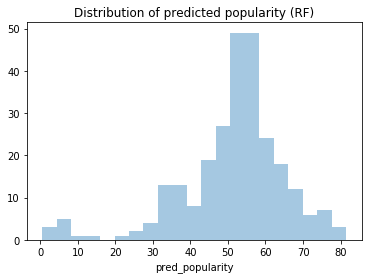

In [112]:
# Plot popularity distribution
sns.distplot(dev_data["pred_popularity"], rug=False, kde=False).set_title("Distribution of predicted popularity (RF)")

## Gradient Boosting Regressor

In [133]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [134]:
test_preds = gbr.predict(x_dev)
print("Gradient Boosting Regressor Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Gradient Boosting Regressor Variance Score: {}".format(r2_score(test_preds, y_dev)))

Gradient Boosting Regressor Mean Squared Error: 190.15995997595633
Gradient Boosting Regressor Variance Score: -0.37321908472561116


In [115]:
## XG Boosting Regressor (Hyperparamterized Gradient Boosting)

In [116]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import itertools

In [117]:
XGB = XGBRegressor(
    learning_rate=0.1,
    n_estimators=400,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=1)

XGB.fit(x_train, y_train)
test_preds = XGB.predict(x_dev)
accuracy = XGB.score(x_dev, y_dev)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("MSE: %.2f"
      % mean_squared_error(test_preds, y_dev))

Accuracy: 56.59%
MSE: 156.33


In [118]:
lr = [0.1, 0.3]
n_estimators = [300, 400]
max_depth = [3, 4]

gridsearch = []

for prod in itertools.product(lr, n_estimators, max_depth):
    gridsearch.append(prod)
gridsearch

[(0.1, 300, 3),
 (0.1, 300, 4),
 (0.1, 400, 3),
 (0.1, 400, 4),
 (0.3, 300, 3),
 (0.3, 300, 4),
 (0.3, 400, 3),
 (0.3, 400, 4)]

In [119]:
for hparams in gridsearch:
    lr, n_est, max_d = hparams
    print("Lr, num est, max depth: ", lr, n_est, max_d)
    XGB = XGBRegressor(
        learning_rate=lr,
        n_estimators=n_est,
        max_depth=max_d,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1)

    XGB.fit(x_train, y_train)
    test_preds = XGB.predict(x_dev)
    accuracy = XGB.score(x_dev, y_dev)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("MSE: %.2f"
          % mean_squared_error(test_preds, y_dev))

Lr, num est, max depth:  0.1 300 3
Accuracy: 59.50%
MSE: 145.85
Lr, num est, max depth:  0.1 300 4
Accuracy: 56.66%
MSE: 156.05
Lr, num est, max depth:  0.1 400 3
Accuracy: 58.64%
MSE: 148.95
Lr, num est, max depth:  0.1 400 4
Accuracy: 55.92%
MSE: 158.75
Lr, num est, max depth:  0.3 300 3
Accuracy: 49.04%
MSE: 183.49
Lr, num est, max depth:  0.3 300 4
Accuracy: 50.48%
MSE: 178.31
Lr, num est, max depth:  0.3 400 3
Accuracy: 47.82%
MSE: 187.90
Lr, num est, max depth:  0.3 400 4
Accuracy: 50.52%
MSE: 178.18


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

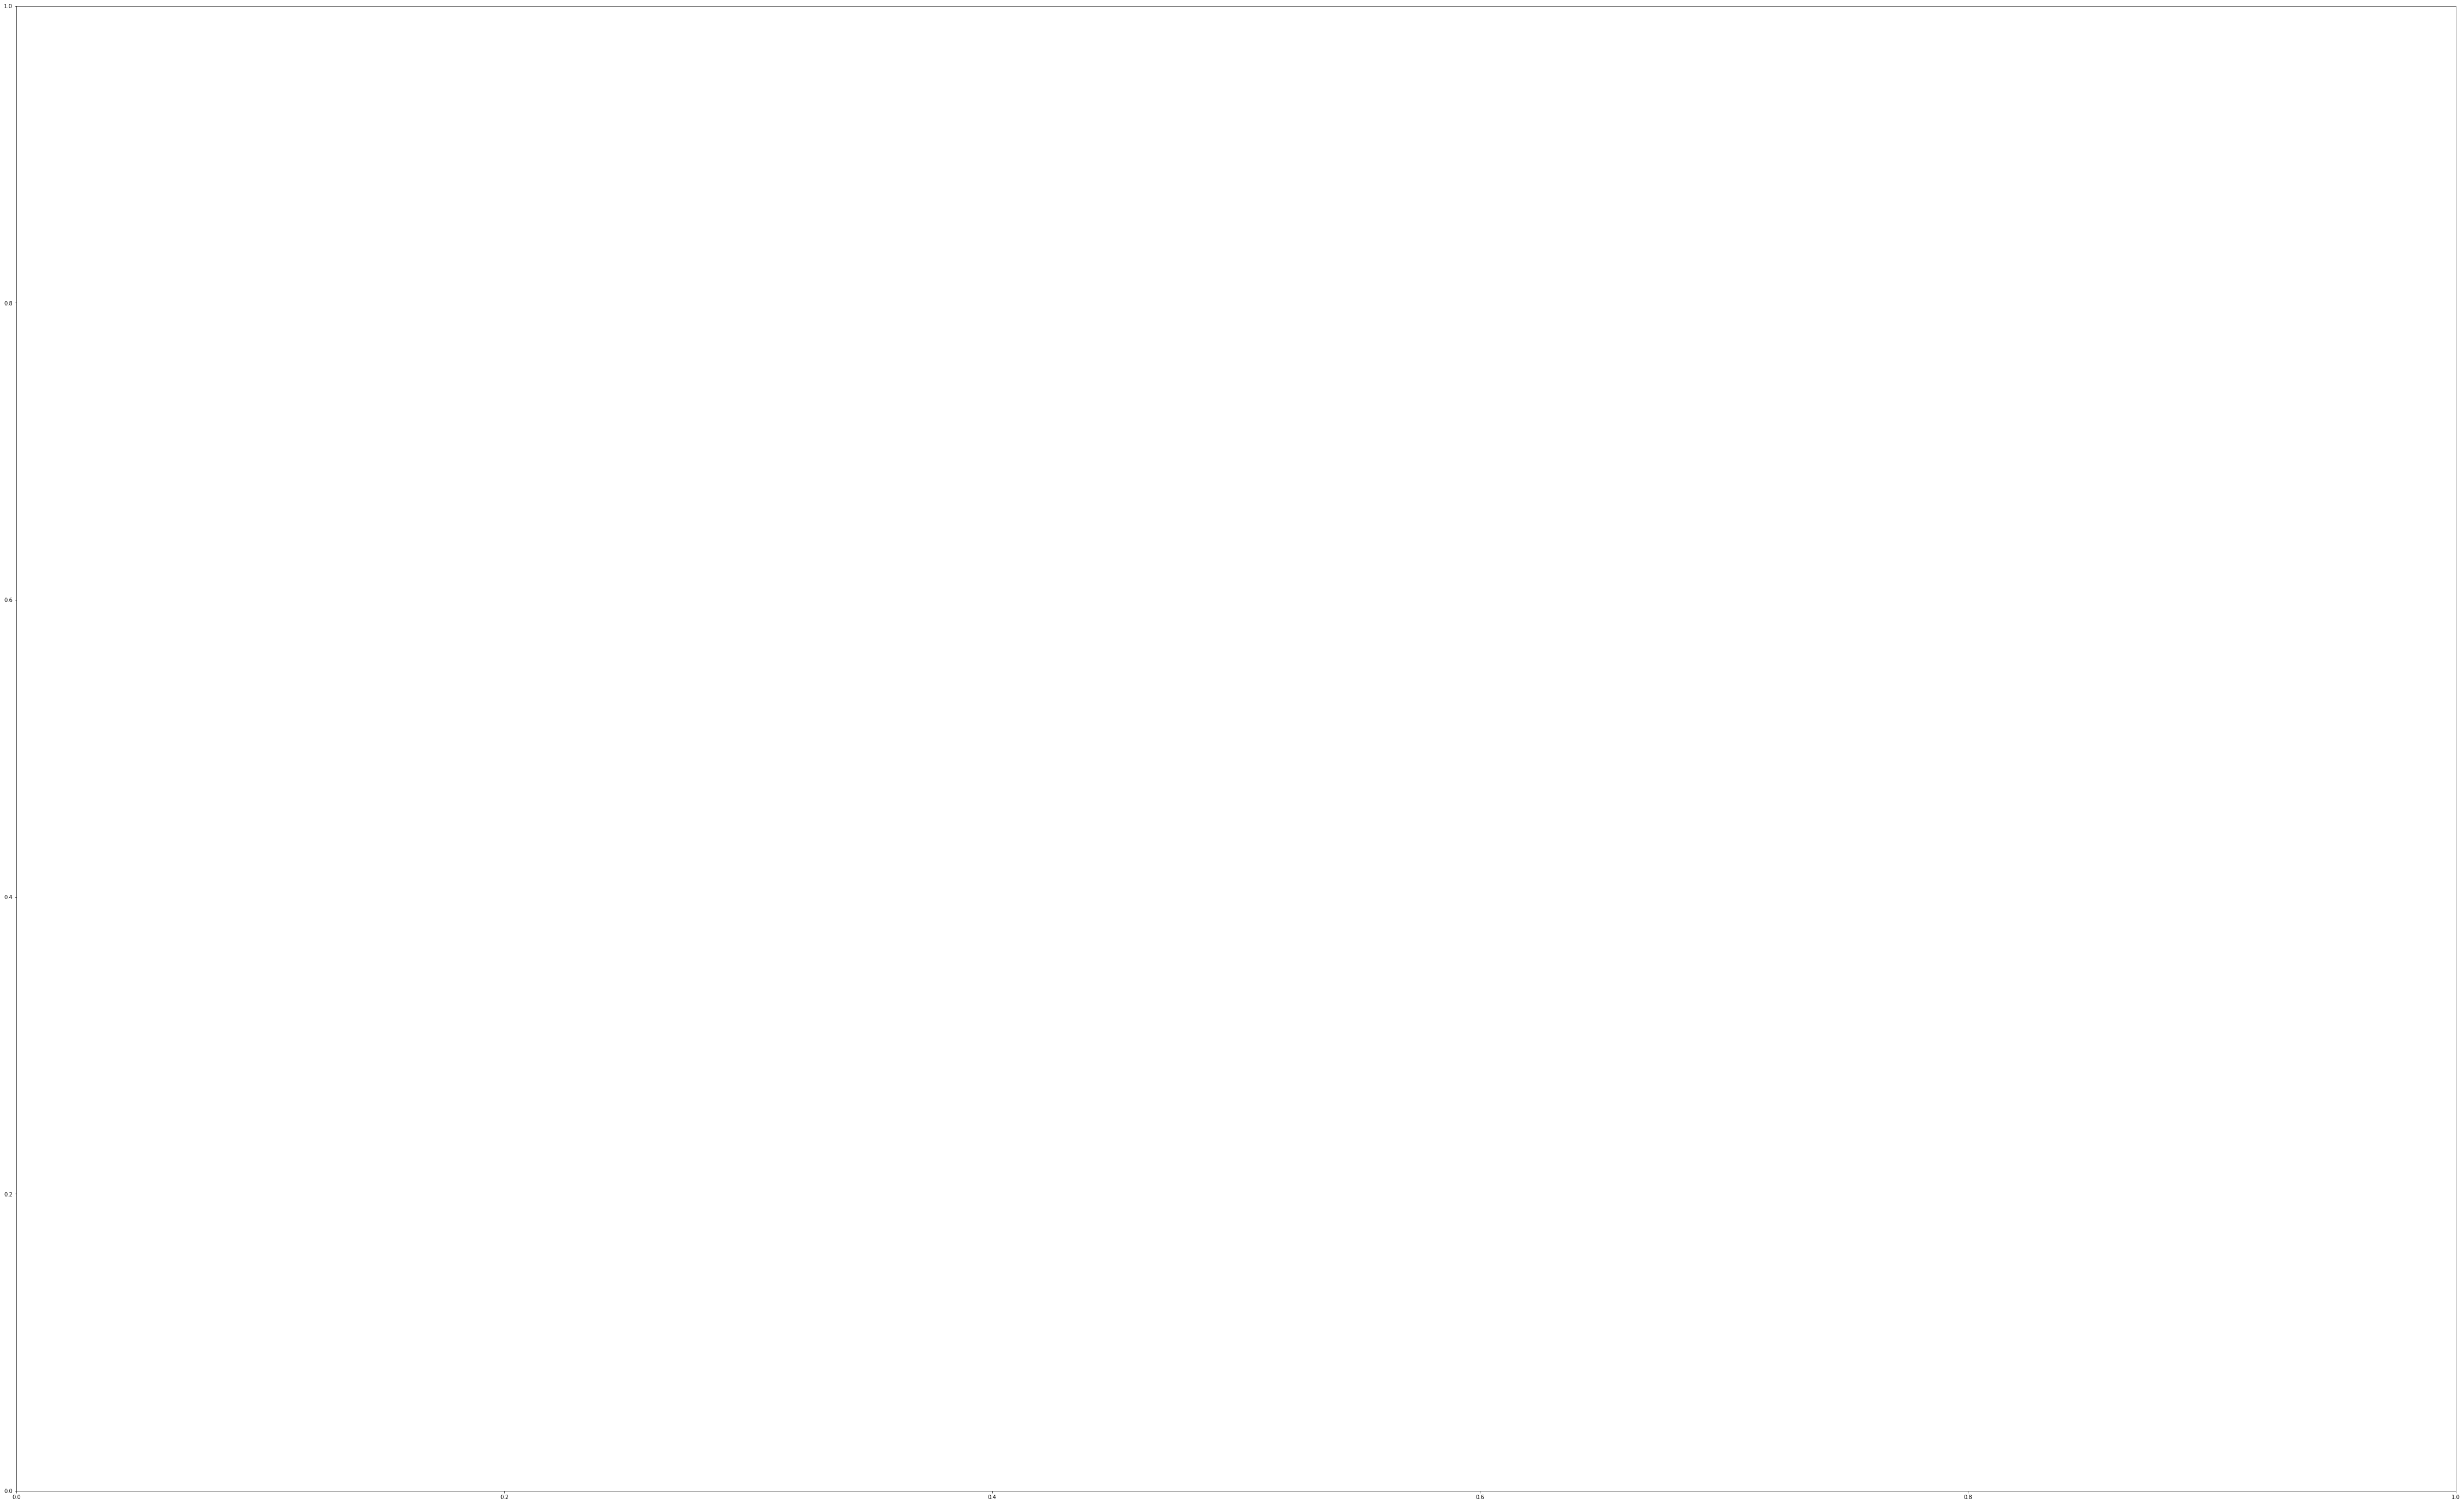

In [34]:
# Comment out to save memory

rcParams['figure.figsize'] = 80,50
plot_tree(XGB)
fig = plt.gcf()
fig.set_size_inches(50, 30)
fig.savefig('tree.eps')

In [ ]:
feat_imp = pd.Series(XGB.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar')
plt.xticks(size = 50)
plt.yticks(size = 60)
plt.suptitle('Feature Importances', fontsize=60)
plt.ylabel('Feature Importance Score', size = 60)
plt.savefig("FE.eps")